In [1]:
# ============================================================
# CÉLULA 1: Descrição do Projeto
# ============================================================
"""
Este notebook faz parte do projeto HBR (CIIA),
focado em validar modelos de detecção de anomalias em logs de sistemas
usando o dataset BETH — um conjunto realista de dados de segurança cibernética.

Objetivo:
- Aplicar um modelo não-supervisionado (Autoencoder) para detectar eventos maliciosos.
- Treinar o AE apenas com logs normais e usar erro de reconstrução como score de anomalia.
- Analisar a estrutura dos logs e as features derivadas.
- Preparar a base conceitual para aplicações futuras em dados reais do CIIA.

Abordagem:
- Autoencoder aprende a reconstruir padrões normais
- Eventos maliciosos (anômalos) terão erro de reconstrução maior
- Threshold baseado no percentil 99 dos dados normais
"""

'\nEste notebook faz parte do projeto HBR (CIIA),\nfocado em validar modelos de detecção de anomalias em logs de sistemas\nusando o dataset BETH — um conjunto realista de dados de segurança cibernética.\n\nObjetivo:\n- Aplicar um modelo não-supervisionado (Autoencoder) para detectar eventos maliciosos.\n- Treinar o AE apenas com logs normais e usar erro de reconstrução como score de anomalia.\n- Analisar a estrutura dos logs e as features derivadas.\n- Preparar a base conceitual para aplicações futuras em dados reais do CIIA.\n\nAbordagem:\n- Autoencoder aprende a reconstruir padrões normais\n- Eventos maliciosos (anômalos) terão erro de reconstrução maior\n- Threshold baseado no percentil 99 dos dados normais\n'

In [2]:
# ============================================================
# CÉLULA 2: Imports e Configurações
# ============================================================
import os, ast, warnings, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)
print("Versão TensorFlow:", tf.__version__)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

2025-10-18 11:58:10.834149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760788690.994572      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760788691.046206      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Versão TensorFlow: 2.18.0
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# ============================================================
# CÉLULA 3: Carregamento dos Dados
# ============================================================
try:
    from kagglehub import dataset_download
    dataset_path = dataset_download("katehighnam/beth-dataset")
except Exception:
    dataset_path = "/kaggle/working"  # ajuste se já tiver os csvs localmente

train_path = os.path.join(dataset_path, "labelled_training_data.csv")
test_path  = os.path.join(dataset_path, "labelled_testing_data.csv")

data_train = pd.read_csv(train_path)
data_test  = pd.read_csv(test_path)
print("Shapes (raw):", data_train.shape, data_test.shape)
print("\nPrimeiras linhas do dataset de treino:")
print(data_train.head())

Shapes (raw): (763144, 16) (188967, 16)

Primeiras linhas do dataset de treino:
     timestamp  processId  threadId  parentProcessId  userId  mountNamespace  \
0  1809.495787        381      7337                1     100      4026532231   
1  1809.495832        381      7337                1     100      4026532231   
2  1809.495921        381      7337                1     100      4026532231   
3  1894.139651       7347      7347             7341       0      4026531840   
4  1894.142127       7347      7347             7341       0      4026531840   

  processName         hostName  eventId           eventName  \
0       close  ip-10-100-1-120      157               prctl   
1       close  ip-10-100-1-120        3               close   
2       close  ip-10-100-1-120     1010  sched_process_exit   
3          sh  ip-10-100-1-120       21              access   
4          sh  ip-10-100-1-120     1005  security_file_open   

                         stackAddresses  argsNum  returnValu


=== ANÁLISE EXPLORATÓRIA ===

Valores nulos (top 10):
timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
dtype: int64

Distribuição target 'evil' (treino original):
evil
0    763144
Name: count, dtype: int64

Proporção de eventos maliciosos: 0.00%


Text(0.5, 0, 'Evil (0=Normal, 1=Malicioso)')

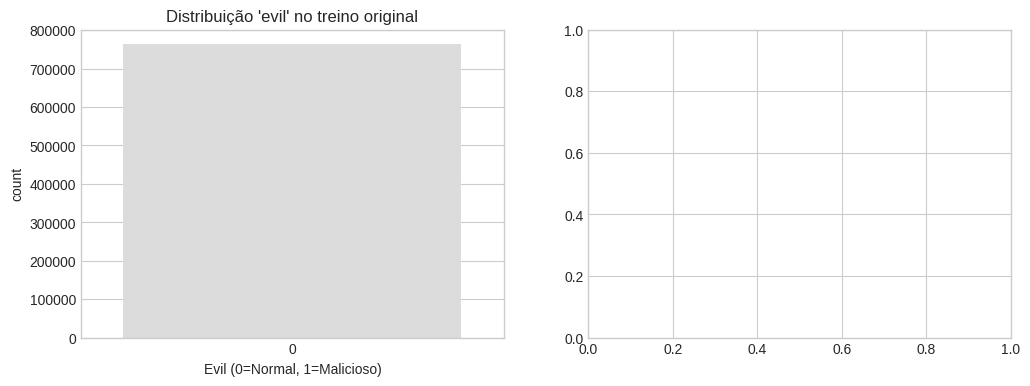

In [4]:
# ============================================================
# CÉLULA 4: Análise Exploratória (EDA)
# ============================================================
print("\n=== ANÁLISE EXPLORATÓRIA ===")
print("\nValores nulos (top 10):")
print(data_train.isna().sum().sort_values(ascending=False).head(10))

print("\nDistribuição target 'evil' (treino original):")
print(data_train['evil'].value_counts(dropna=False))
print(f"\nProporção de eventos maliciosos: {data_train['evil'].mean()*100:.2f}%")

# Visualização da distribuição
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='evil', data=data_train, palette='coolwarm', ax=ax[0])
ax[0].set_title("Distribuição 'evil' no treino original")
ax[0].set_xlabel("Evil (0=Normal, 1=Malicioso)")

In [5]:
# ============================================================
# CÉLULA 5: Engenharia de Features - stackAddresses
# ============================================================
def safe_parse_stack(x):
    """Parser seguro para stackAddresses (pode ser string ou lista)"""
    try:
        if pd.isna(x) or x == '[]':
            return []
        if isinstance(x, list):
            return x
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

def extract_stack_features(df):
    """Extrai features estatísticas de stackAddresses"""
    s = df['stackAddresses'].astype(str).apply(safe_parse_stack)
    df = df.copy()
    df['stack_len']  = s.apply(len)
    df['stack_max']  = s.apply(lambda l: max(l) if l else 0)
    df['stack_min']  = s.apply(lambda l: min(l) if l else 0)
    df['stack_mean'] = s.apply(lambda l: np.mean(l) if l else 0)
    df = df.drop(columns=['stackAddresses'])
    return df

print("\n=== EXTRAÇÃO DE FEATURES DE STACK ===")
data_train = extract_stack_features(data_train)
data_test  = extract_stack_features(data_test)
print("Stack features extraídas: stack_len, stack_max, stack_min, stack_mean")


=== EXTRAÇÃO DE FEATURES DE STACK ===
Stack features extraídas: stack_len, stack_max, stack_min, stack_mean


In [6]:
# ============================================================
# CÉLULA 6: Redução de Cardinalidade (Top-K)
# ============================================================
TOP_K_PROC  = 50
TOP_K_EVENT = 50

def top_k_replace(df_train, df_test, col, k):
    """Mantém apenas os top-K valores mais frequentes, agrupando resto em '__other__'"""
    topk = df_train[col].value_counts().nlargest(k).index
    df_train[col] = df_train[col].where(df_train[col].isin(topk), other="__other__")
    df_test[col]  = df_test[col].where(df_test[col].isin(topk), other="__other__")
    return df_train, df_test

print("\n=== REDUÇÃO DE CARDINALIDADE ===")
for c in ['processName', 'eventName']:
    if c in data_train.columns:
        k = TOP_K_PROC if c == 'processName' else TOP_K_EVENT
        unique_before = data_train[c].nunique()
        data_train, data_test = top_k_replace(data_train, data_test, c, k)
        unique_after = data_train[c].nunique()
        print(f"{c}: {unique_before} → {unique_after} categorias únicas")


=== REDUÇÃO DE CARDINALIDADE ===
processName: 36 → 36 categorias únicas
eventName: 32 → 32 categorias únicas


In [7]:
# ============================================================
# CÉLULA 7: Remoção de Colunas Irrelevantes
# ============================================================
cols_drop = ['hostName', 'timestamp', 'args']  # args costuma ser pesado/complexo
for c in cols_drop:
    if c in data_train.columns:
        data_train = data_train.drop(columns=c, errors='ignore')
        data_test  = data_test.drop(columns=c, errors='ignore')
        print(f"Coluna '{c}' removida")

Coluna 'hostName' removida
Coluna 'timestamp' removida
Coluna 'args' removida


In [8]:
# ============================================================
# CÉLULA 8: One-Hot Encoding
# ============================================================
print("\n=== ONE-HOT ENCODING ===")
categorical_cols = [c for c in ['processName', 'eventName'] if c in data_train.columns]
print(f"Colunas categóricas: {categorical_cols}")

X_train = pd.get_dummies(data_train.drop(columns=['evil']), columns=categorical_cols, dummy_na=False)
X_test  = pd.get_dummies(data_test.drop(columns=['evil']),  columns=categorical_cols, dummy_na=False)

# Garantir mesmas colunas em train e test
all_cols = X_train.columns.union(X_test.columns)
X_train = X_train.reindex(columns=all_cols, fill_value=0)
X_test  = X_test.reindex(columns=all_cols, fill_value=0)

y_train = data_train['evil'].copy()
y_test  = data_test['evil'].copy()

print(f"Shapes após OHE: X_train {X_train.shape}, X_test {X_test.shape}")
print(f"Total de features: {X_train.shape[1]}")
print("\nDistribuição target (train):")
print(y_train.value_counts())


=== ONE-HOT ENCODING ===
Colunas categóricas: ['processName', 'eventName']
Shapes após OHE: X_train (763144, 83), X_test (188967, 83)
Total de features: 83

Distribuição target (train):
evil
0    763144
Name: count, dtype: int64


In [9]:
# ============================================================
# CÉLULA 9: Split Train/Validation
# ============================================================
print("\n=== SPLIT TRAIN/VALIDATION ===")
X_tr_full, X_val, y_tr_full, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)
print(f"X_train: {X_tr_full.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")


=== SPLIT TRAIN/VALIDATION ===
X_train: (610515, 83)
X_val:   (152629, 83)
X_test:  (188967, 83)


In [10]:
# ============================================================
# CÉLULA 10: Preparação para Autoencoder (apenas normais)
# ============================================================
print("\n=== PREPARAÇÃO PARA AUTOENCODER ===")
# IMPORTANTE: AE treinado apenas com dados NORMAIS (evil=0)
X_tr_norm = X_tr_full[y_tr_full == 0]
print(f"Dados normais para treinar AE: {X_tr_norm.shape}")
print(f"Proporção usada: {len(X_tr_norm)/len(X_tr_full)*100:.1f}% do conjunto de treino")

# Normalização (StandardScaler ajustado apenas nos normais)
scaler = StandardScaler()
scaler.fit(X_tr_norm)

X_tr_norm_scaled = scaler.transform(X_tr_norm)
X_tr_full_scaled = scaler.transform(X_tr_full)
X_val_scaled     = scaler.transform(X_val)
X_test_scaled    = scaler.transform(X_test)

print("Normalização concluída (StandardScaler)")


=== PREPARAÇÃO PARA AUTOENCODER ===
Dados normais para treinar AE: (610515, 83)
Proporção usada: 100.0% do conjunto de treino
Normalização concluída (StandardScaler)


In [11]:
# ============================================================
# CÉLULA 11: Construção do Autoencoder
# ============================================================
print("\n=== CONSTRUÇÃO DO AUTOENCODER ===")
input_dim = X_tr_norm_scaled.shape[1]
encoding_dim = min(32, max(4, input_dim // 20))  # dimensão do bottleneck
print(f"Input dimension: {input_dim}")
print(f"Encoding dimension (bottleneck): {encoding_dim}")

# Definição da arquitetura
tf.random.set_seed(42)

ae_input = layers.Input(shape=(input_dim,), name='input')

# Encoder
x = layers.Dense(256, activation='relu', name='enc_dense1')(ae_input)
x = layers.BatchNormalization(name='enc_bn1')(x)
x = layers.Dropout(0.2, name='enc_dropout1')(x)

x = layers.Dense(128, activation='relu', name='enc_dense2')(x)
x = layers.BatchNormalization(name='enc_bn2')(x)
x = layers.Dropout(0.2, name='enc_dropout2')(x)

latent = layers.Dense(encoding_dim, activation='relu', name='latent')(x)

# Decoder
x = layers.Dense(128, activation='relu', name='dec_dense1')(latent)
x = layers.BatchNormalization(name='dec_bn1')(x)
x = layers.Dropout(0.2, name='dec_dropout1')(x)

x = layers.Dense(256, activation='relu', name='dec_dense2')(x)
x = layers.BatchNormalization(name='dec_bn2')(x)
x = layers.Dropout(0.2, name='dec_dropout2')(x)

ae_output = layers.Dense(input_dim, activation='linear', name='output')(x)

# Modelos
autoencoder = models.Model(ae_input, ae_output, name='autoencoder')
encoder = models.Model(ae_input, latent, name='encoder')

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
autoencoder.summary()


=== CONSTRUÇÃO DO AUTOENCODER ===
Input dimension: 83
Encoding dimension (bottleneck): 4


I0000 00:00:1760788720.649472      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 83)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense1 (Dense)              │ (None, 256)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn1 (BatchNormalization)    │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout1 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense2 (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn2 (BatchNormalization)    │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout2 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 4)              │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense1 (Dense)              │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn1 (BatchNormalization)    │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout1 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense2 (Dense)              │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn2 (BatchNormalization)    │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout2 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 83)             │        21,331 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,983 (441.34 KB)

 Trainable params: 111,447 (435.34 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [12]:
# ============================================================
# CÉLULA 12: Treinamento do Autoencoder
# ============================================================
print("\n=== TREINAMENTO DO AUTOENCODER ===")
print("Treinando apenas com dados NORMAIS...")

es = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = autoencoder.fit(
    X_tr_norm_scaled, X_tr_norm_scaled,
    validation_split=0.1,
    epochs=4,
    batch_size=512,
    callbacks=[es, reduce_lr],
    verbose=1
)

print("\nTreinamento concluído!")


=== TREINAMENTO DO AUTOENCODER ===
Treinando apenas com dados NORMAIS...
Epoch 1/4


I0000 00:00:1760788727.499096      59 service.cc:148] XLA service 0x79fd0c0029a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760788727.499652      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760788727.990201      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  55/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8530 - mae: 0.7414

I0000 00:00:1760788730.961455      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 1.0050 - mae: 0.3999 - val_loss: 0.4831 - val_mae: 0.1142 - learning_rate: 0.0010
Epoch 2/4
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5110 - mae: 0.1826 - val_loss: 0.3606 - val_mae: 0.0861 - learning_rate: 0.0010
Epoch 3/4
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4237 - mae: 0.1558 - val_loss: 0.3517 - val_mae: 0.0839 - learning_rate: 0.0010
Epoch 4/4
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3794 - mae: 0.1448 - val_loss: 0.3362 - val_mae: 0.0763 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.

Treinamento concluído!


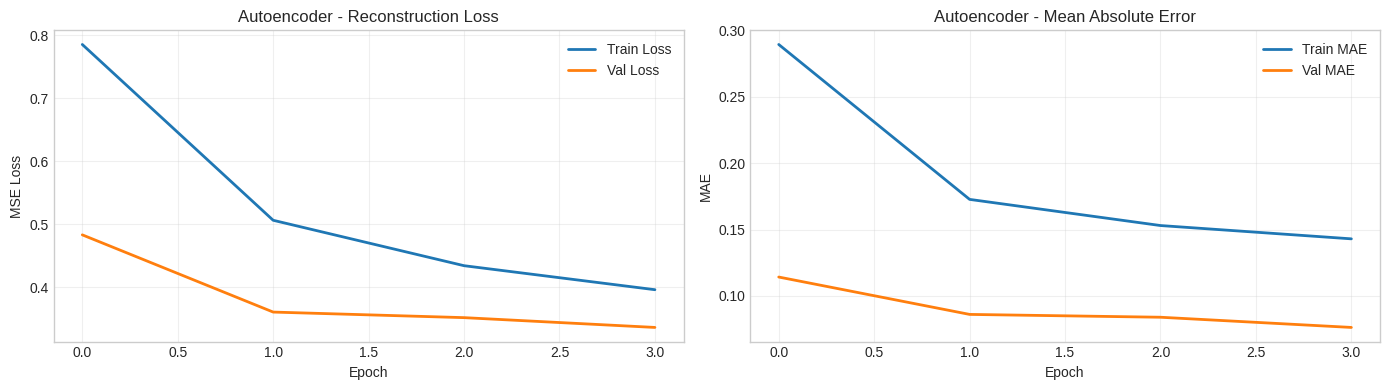

In [13]:
# ============================================================
# CÉLULA 13: Visualização do Treinamento
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Autoencoder - Reconstruction Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Autoencoder - Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
# ============================================================
# CÉLULA 14: Cálculo de Erro de Reconstrução
# ============================================================
print("\n=== CÁLCULO DE ERRO DE RECONSTRUÇÃO ===")

# Predições (reconstruções)
X_tr_full_recon = autoencoder.predict(X_tr_full_scaled, batch_size=1024, verbose=0)
X_val_recon     = autoencoder.predict(X_val_scaled, batch_size=1024, verbose=0)
X_test_recon    = autoencoder.predict(X_test_scaled, batch_size=1024, verbose=0)

# MSE por amostra
train_mse = np.mean(np.square(X_tr_full_scaled - X_tr_full_recon), axis=1)
val_mse   = np.mean(np.square(X_val_scaled - X_val_recon), axis=1)
test_mse  = np.mean(np.square(X_test_scaled - X_test_recon), axis=1)

print("Estatísticas de MSE:")
print(f"Train - Min: {np.min(train_mse):.6f}, Median: {np.median(train_mse):.6f}, Max: {np.max(train_mse):.6f}")
print(f"Val   - Min: {np.min(val_mse):.6f}, Median: {np.median(val_mse):.6f}, Max: {np.max(val_mse):.6f}")
print(f"Test  - Min: {np.min(test_mse):.6f}, Median: {np.median(test_mse):.6f}, Max: {np.max(test_mse):.6f}")


=== CÁLCULO DE ERRO DE RECONSTRUÇÃO ===
Estatísticas de MSE:
Train - Min: 0.002407, Median: 0.010266, Max: 8535.288848
Val   - Min: 0.002407, Median: 0.010260, Max: 8535.320726
Test  - Min: 0.003249, Median: 4.387722, Max: 2629.850221


In [15]:
# ============================================================
# CÉLULA 15: Definição de Threshold
# ============================================================
print("\n=== DEFINIÇÃO DE THRESHOLD ===")

# Threshold baseado no percentil 99 dos dados NORMAIS de treino
train_norm_mse = train_mse[y_tr_full == 0]
threshold_p99 = np.percentile(train_norm_mse, 99)

print(f"Threshold (99th percentile dos normais): {threshold_p99:.6f}")
print(f"Interpretação: ~99% dos dados normais têm erro < threshold")

# Testando outros percentis
for p in [95, 98, 99, 99.5]:
    thr = np.percentile(train_norm_mse, p)
    print(f"Percentil {p}: {thr:.6f}")


=== DEFINIÇÃO DE THRESHOLD ===
Threshold (99th percentile dos normais): 1.445556
Interpretação: ~99% dos dados normais têm erro < threshold
Percentil 95: 0.229619
Percentil 98: 0.704089
Percentil 99: 1.445556
Percentil 99.5: 2.254145



=== ANÁLISE DE ERRO POR CLASSE ===
TRAIN SET:
  Normal (0): mean=0.348748, std=23.191705
  Evil (1):   mean=nan, std=nan

TEST SET:
  Normal (0): mean=7.199846, std=84.358336
  Evil (1):   mean=4.401386, std=9.408040


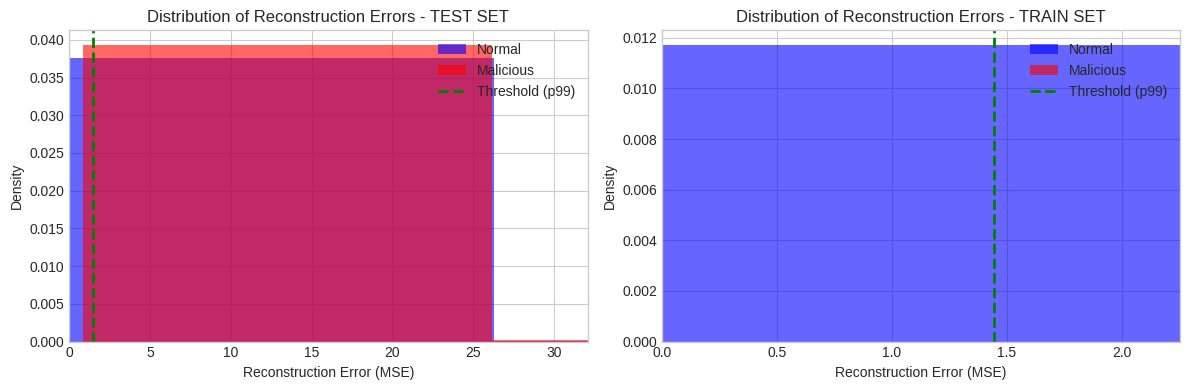

In [16]:
# ============================================================
# CÉLULA 16: Análise de Erro por Classe
# ============================================================
print("\n=== ANÁLISE DE ERRO POR CLASSE ===")

# Train
train_mse_normal = train_mse[y_tr_full == 0]
train_mse_evil = train_mse[y_tr_full == 1]

# Test
test_mse_normal = test_mse[y_test == 0]
test_mse_evil = test_mse[y_test == 1]

print("TRAIN SET:")
print(f"  Normal (0): mean={np.mean(train_mse_normal):.6f}, std={np.std(train_mse_normal):.6f}")
print(f"  Evil (1):   mean={np.mean(train_mse_evil):.6f}, std={np.std(train_mse_evil):.6f}")

print("\nTEST SET:")
print(f"  Normal (0): mean={np.mean(test_mse_normal):.6f}, std={np.std(test_mse_normal):.6f}")
print(f"  Evil (1):   mean={np.mean(test_mse_evil):.6f}, std={np.std(test_mse_evil):.6f}")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Test set
axes[0].hist(test_mse_normal, bins=100, alpha=0.6, label='Normal', density=True, color='blue')
axes[0].hist(test_mse_evil, bins=100, alpha=0.6, label='Malicious', density=True, color='red')
axes[0].axvline(threshold_p99, color='green', linestyle='--', linewidth=2, label=f'Threshold (p99)')
axes[0].set_xlabel('Reconstruction Error (MSE)')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Reconstruction Errors - TEST SET')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(test_mse, 99.5))

# Train set
axes[1].hist(train_mse_normal, bins=100, alpha=0.6, label='Normal', density=True, color='blue')
axes[1].hist(train_mse_evil, bins=100, alpha=0.6, label='Malicious', density=True, color='red')
axes[1].axvline(threshold_p99, color='green', linestyle='--', linewidth=2, label=f'Threshold (p99)')
axes[1].set_xlabel('Reconstruction Error (MSE)')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Reconstruction Errors - TRAIN SET')
axes[1].legend()
axes[1].set_xlim(0, np.percentile(train_mse, 99.5))

plt.tight_layout()
plt.show()


=== AVALIAÇÃO NO CONJUNTO DE VALIDAÇÃO ===
Distribuição de classes no conjunto de validação:
evil
0    152629
Name: count, dtype: int64
Classes únicas: 1

Classification Report (Validation):
              precision    recall  f1-score   support

      Normal     1.0000    0.9899    0.9949    152629
   Malicious     0.0000    0.0000    0.0000         0

    accuracy                         0.9899    152629
   macro avg     0.5000    0.4950    0.4975    152629
weighted avg     1.0000    0.9899    0.9949    152629


ROC AUC: Não pode ser calculado (apenas uma classe presente)


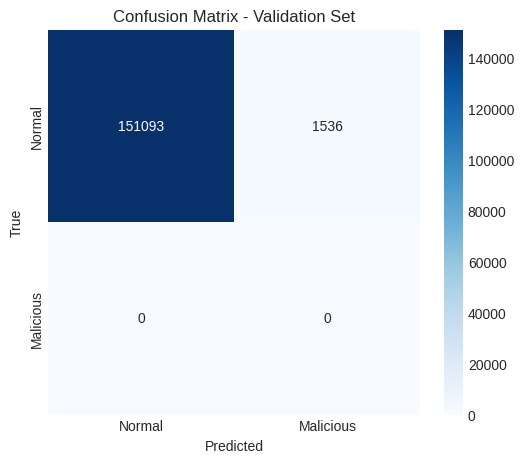

In [17]:
# ============================================================
# CÉLULA 17: Avaliação no Conjunto de Validação
# ============================================================
print("\n=== AVALIAÇÃO NO CONJUNTO DE VALIDAÇÃO ===")

# Verificar distribuição de classes
print(f"Distribuição de classes no conjunto de validação:")
print(y_val.value_counts())
print(f"Classes únicas: {y_val.nunique()}")

val_predictions = (val_mse > threshold_p99).astype(int)

print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions, digits=4, target_names=['Normal', 'Malicious']))

# ROC AUC (apenas se houver ambas as classes)
if y_val.nunique() > 1:
    try:
        val_roc_auc = roc_auc_score(y_val, val_mse)
        print(f"\nROC AUC (using MSE as score): {val_roc_auc:.4f}")
    except Exception as e:
        print(f"\nErro ao calcular ROC AUC: {e}")
        val_roc_auc = None
else:
    print("\nROC AUC: Não pode ser calculado (apenas uma classe presente)")
    val_roc_auc = None

# Confusion Matrix
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Malicious'],
            yticklabels=['Normal', 'Malicious'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


=== AVALIAÇÃO NO CONJUNTO DE TESTE ===
Distribuição de classes no conjunto de teste:
evil
1    158432
0     30535
Name: count, dtype: int64
Classes únicas: 2

Classification Report (Test):
              precision    recall  f1-score   support

      Normal     0.7074    0.6729    0.6897     30535
   Malicious     0.9375    0.9463    0.9419    158432

    accuracy                         0.9022    188967
   macro avg     0.8225    0.8096    0.8158    188967
weighted avg     0.9004    0.9022    0.9012    188967


ROC AUC (using MSE as score): 0.6904


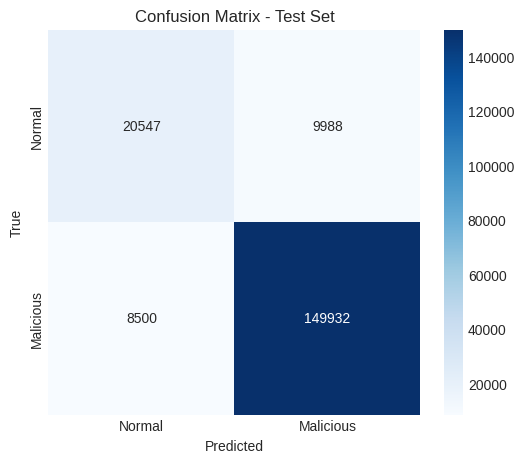

In [18]:
# ============================================================
# CÉLULA 18: Avaliação no Conjunto de Teste
# ============================================================
print("\n=== AVALIAÇÃO NO CONJUNTO DE TESTE ===")

# Verificar distribuição de classes
print(f"Distribuição de classes no conjunto de teste:")
print(y_test.value_counts())
print(f"Classes únicas: {y_test.nunique()}")

test_predictions = (test_mse > threshold_p99).astype(int)

print("\nClassification Report (Test):")
print(classification_report(y_test, test_predictions, digits=4, target_names=['Normal', 'Malicious']))

# ROC AUC (apenas se houver ambas as classes)
if y_test.nunique() > 1:
    try:
        test_roc_auc = roc_auc_score(y_test, test_mse)
        print(f"\nROC AUC (using MSE as score): {test_roc_auc:.4f}")
    except Exception as e:
        print(f"\nErro ao calcular ROC AUC: {e}")
        test_roc_auc = None
else:
    print("\nROC AUC: Não pode ser calculado (apenas uma classe presente)")
    test_roc_auc = None

# Confusion Matrix
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Malicious'],
            yticklabels=['Normal', 'Malicious'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


=== CURVA ROC ===


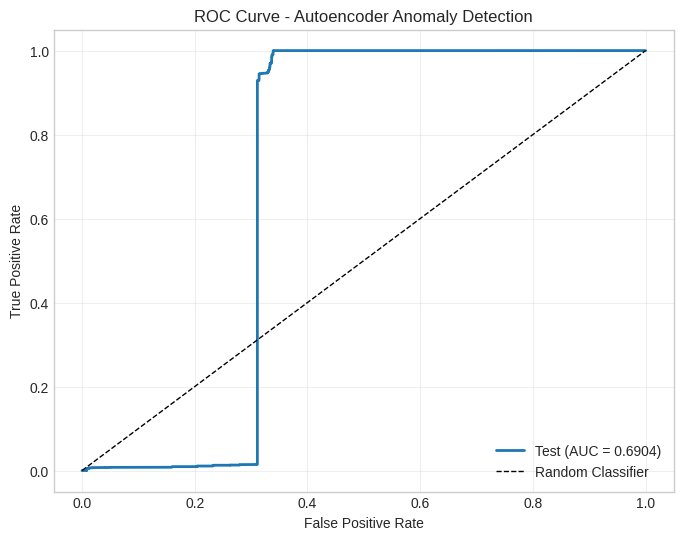

In [19]:
# ============================================================
# CÉLULA 19: Curva ROC
# ============================================================
print("\n=== CURVA ROC ===")

# Calcular ROC apenas se houver ambas as classes
if y_val.nunique() > 1 and y_test.nunique() > 1:
    try:
        # Calcular ROC para validation e test
        fpr_val, tpr_val, _ = roc_curve(y_val, val_mse)
        roc_auc_val = auc(fpr_val, tpr_val)
        
        fpr_test, tpr_test, _ = roc_curve(y_test, test_mse)
        roc_auc_test = auc(fpr_test, tpr_test)
        
        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {roc_auc_val:.4f})', linewidth=2)
        plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_test:.4f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Autoencoder Anomaly Detection')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"Erro ao gerar curva ROC: {e}")
elif y_test.nunique() > 1:
    try:
        # Apenas test set
        fpr_test, tpr_test, _ = roc_curve(y_test, test_mse)
        roc_auc_test = auc(fpr_test, tpr_test)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_test:.4f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Autoencoder Anomaly Detection')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"Erro ao gerar curva ROC: {e}")
else:
    print("Curva ROC não pode ser gerada (apenas uma classe presente nos dados)")


=== ANÁLISE DE EMBEDDINGS (LATENT SPACE) ===
Dimensão do espaço latente: 4
Variância explicada pelos 2 componentes: 82.51%


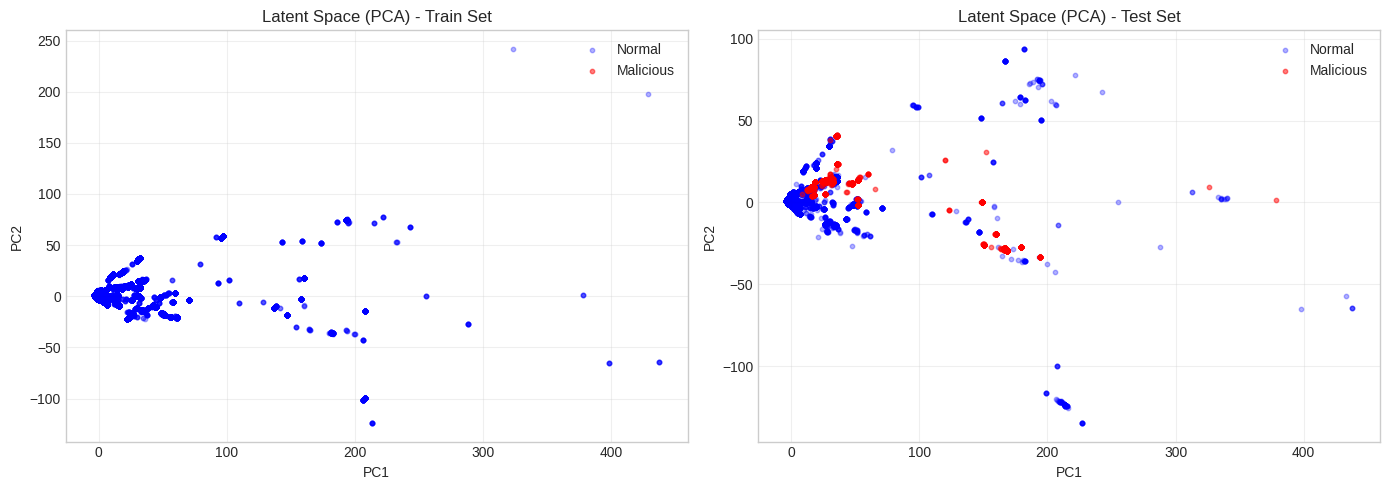

In [20]:
# ============================================================
# CÉLULA 20: Análise de Embeddings (Opcional)
# ============================================================
print("\n=== ANÁLISE DE EMBEDDINGS (LATENT SPACE) ===")

# Gerar embeddings
train_embeddings = encoder.predict(X_tr_full_scaled, batch_size=1024, verbose=0)
test_embeddings = encoder.predict(X_test_scaled, batch_size=1024, verbose=0)

print(f"Dimensão do espaço latente: {train_embeddings.shape[1]}")

# Redução de dimensionalidade para visualização (se possível)
if train_embeddings.shape[1] > 2:
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2, random_state=42)
    train_emb_2d = pca.fit_transform(train_embeddings)
    test_emb_2d = pca.transform(test_embeddings)
    
    print(f"Variância explicada pelos 2 componentes: {pca.explained_variance_ratio_.sum()*100:.2f}%")
    
    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Train
    scatter_train_0 = axes[0].scatter(train_emb_2d[y_tr_full==0, 0], train_emb_2d[y_tr_full==0, 1], 
                                      c='blue', alpha=0.3, s=10, label='Normal')
    scatter_train_1 = axes[0].scatter(train_emb_2d[y_tr_full==1, 0], train_emb_2d[y_tr_full==1, 1], 
                                      c='red', alpha=0.5, s=10, label='Malicious')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].set_title('Latent Space (PCA) - Train Set')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Test
    scatter_test_0 = axes[1].scatter(test_emb_2d[y_test==0, 0], test_emb_2d[y_test==0, 1], 
                                     c='blue', alpha=0.3, s=10, label='Normal')
    scatter_test_1 = axes[1].scatter(test_emb_2d[y_test==1, 0], test_emb_2d[y_test==1, 1], 
                                     c='red', alpha=0.5, s=10, label='Malicious')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    axes[1].set_title('Latent Space (PCA) - Test Set')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== OTIMIZAÇÃO DE THRESHOLD ===

Resultados por threshold:
 percentile  threshold  precision   recall       f1
       90.0   0.116398   0.896311 1.000000 0.945321
       95.0   0.229619   0.910790 1.000000 0.953313
       97.0   0.466719   0.915930 1.000000 0.956120
       98.0   0.704089   0.935116 1.000000 0.966470
       99.0   1.445556   0.937544 0.946349 0.941926
       99.5   2.254145   0.939229 0.945365 0.942287
       99.9  26.693559   0.729927 0.005049 0.010030


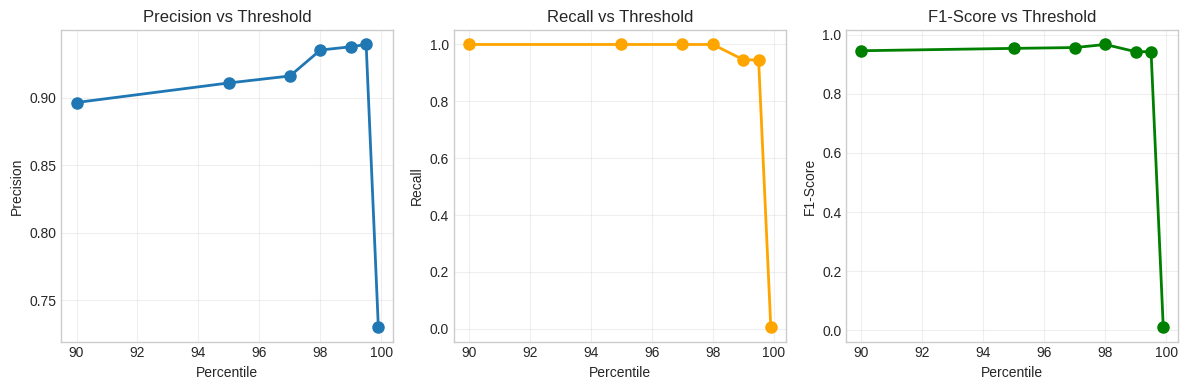


Melhor threshold (baseado em F1):
  Percentil: 98.0
  Threshold: 0.704089
  Precision: 0.9351
  Recall: 1.0000
  F1-Score: 0.9665


In [21]:
# ============================================================
# CÉLULA 21: Otimização de Threshold
# ============================================================
print("\n=== OTIMIZAÇÃO DE THRESHOLD ===")

# Testar diferentes thresholds
percentiles = [90, 95, 97, 98, 99, 99.5, 99.9]
results = []

for p in percentiles:
    thr = np.percentile(train_norm_mse, p)
    preds = (test_mse > thr).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average='binary', zero_division=0
    )
    
    results.append({
        'percentile': p,
        'threshold': thr,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)
print("\nResultados por threshold:")
print(results_df.to_string(index=False))

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(12,4))

axes[0].plot(results_df['percentile'], results_df['precision'], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Percentile')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision vs Threshold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df['percentile'], results_df['recall'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Percentile')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall vs Threshold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_df['percentile'], results_df['f1'], 'o-', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Percentile')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score vs Threshold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Melhor threshold baseado em F1
best_idx = results_df['f1'].idxmax()
best_result = results_df.iloc[best_idx]
print(f"\nMelhor threshold (baseado em F1):")
print(f"  Percentil: {best_result['percentile']}")
print(f"  Threshold: {best_result['threshold']:.6f}")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall: {best_result['recall']:.4f}")
print(f"  F1-Score: {best_result['f1']:.4f}")

In [22]:
# ============================================================
# CÉLULA 22: Resumo Final e Conclusões
# ============================================================
print("\n" + "="*60)
print("RESUMO FINAL - AUTOENCODER PARA DETECÇÃO DE ANOMALIAS")
print("="*60)

print(f"\nArquitetura:")
print(f"  - Input dimension: {input_dim}")
print(f"  - Encoding dimension: {encoding_dim}")
print(f"  - Camadas: Dense(256) → Dense(128) → Dense({encoding_dim}) → Dense(128) → Dense(256) → Output")

print(f"\nDados de Treinamento:")
print(f"  - Total de amostras normais usadas: {len(X_tr_norm)}")
print(f"  - Epochs treinados: {len(history.history['loss'])}")

print(f"\nPerformance no Test Set (threshold p99={threshold_p99:.6f}):")
if test_roc_auc is not None:
    print(f"  - ROC AUC: {test_roc_auc:.3f}")
else:
    print(f"  - ROC AUC: N/A")
test_f1 = f1_score(y_test, test_predictions, zero_division=0)
print(f"  - F1-Score: {test_f1:.3f}")

print(f"\nPerformance com melhor threshold (p{best_result['percentile']}):")
print(f"  - Precision: {best_result['precision']:.3f}")
print(f"  - Recall: {best_result['recall']:.3f}")
print(f"  - F1-Score: {best_result['f1']:.3f}")


RESUMO FINAL - AUTOENCODER PARA DETECÇÃO DE ANOMALIAS

Arquitetura:
  - Input dimension: 83
  - Encoding dimension: 4
  - Camadas: Dense(256) → Dense(128) → Dense(4) → Dense(128) → Dense(256) → Output

Dados de Treinamento:
  - Total de amostras normais usadas: 610515
  - Epochs treinados: 4

Performance no Test Set (threshold p99=1.445556):
  - ROC AUC: 0.690
  - F1-Score: 0.942

Performance com melhor threshold (p98.0):
  - Precision: 0.935
  - Recall: 1.000
  - F1-Score: 0.966
